Using device: cpu
snntorch version: 0.9.4
=== NinaPro EMG Classification with snntorch ===

1. Loading data...
Available keys in the data: ['__header__', '__version__', '__globals__', 'repetition', 'repetition_object', 'acc', 'daytesting', 'emg', 'object', 'reobject', 'rerepetition', 'restimulus', 'stimulus', 'subj', 'time']
EMG data shape: (1428729, 16)
Labels shape: (1428729,)
Unique labels: [ 0  1  3  4  6  9 10 11]

2. Preprocessing data for SNN...
Feature data shape: (8176, 192)
Labels shape: (8176,)
Number of classes: 7

3. Splitting data...
Train set: 5725 samples
Validation set: 1224 samples
Test set: 1227 samples

4. Normalizing features...

5. Creating data loaders...

6. Creating snntorch SNN model...
Model created with 91023 parameters
SNNNet(
  (layers): ModuleList(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_featur

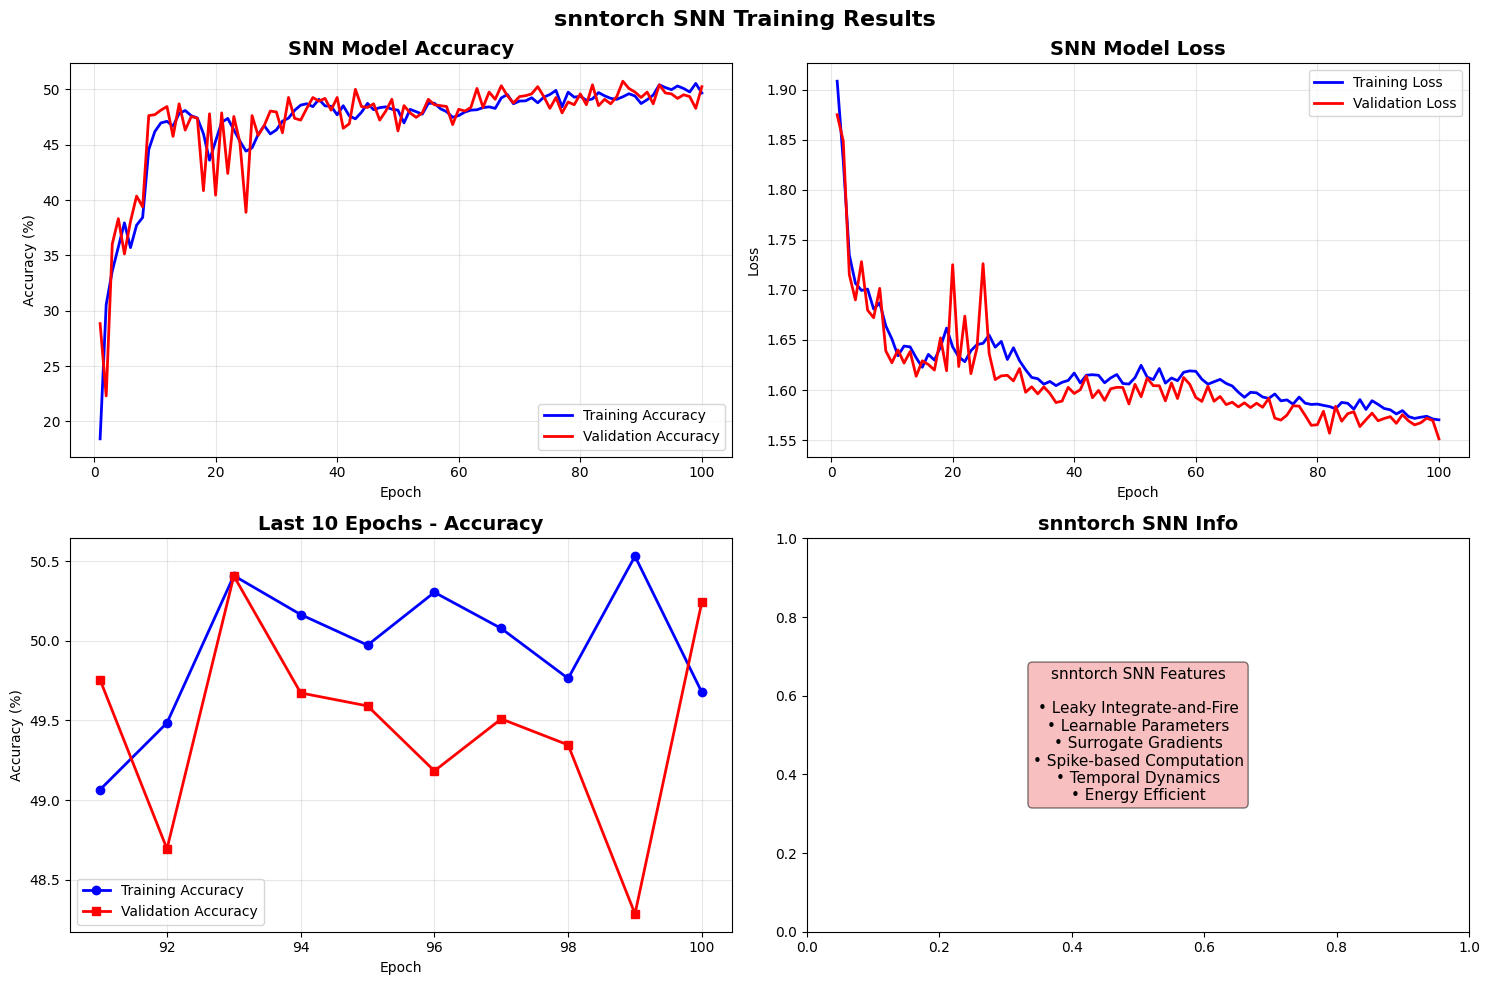

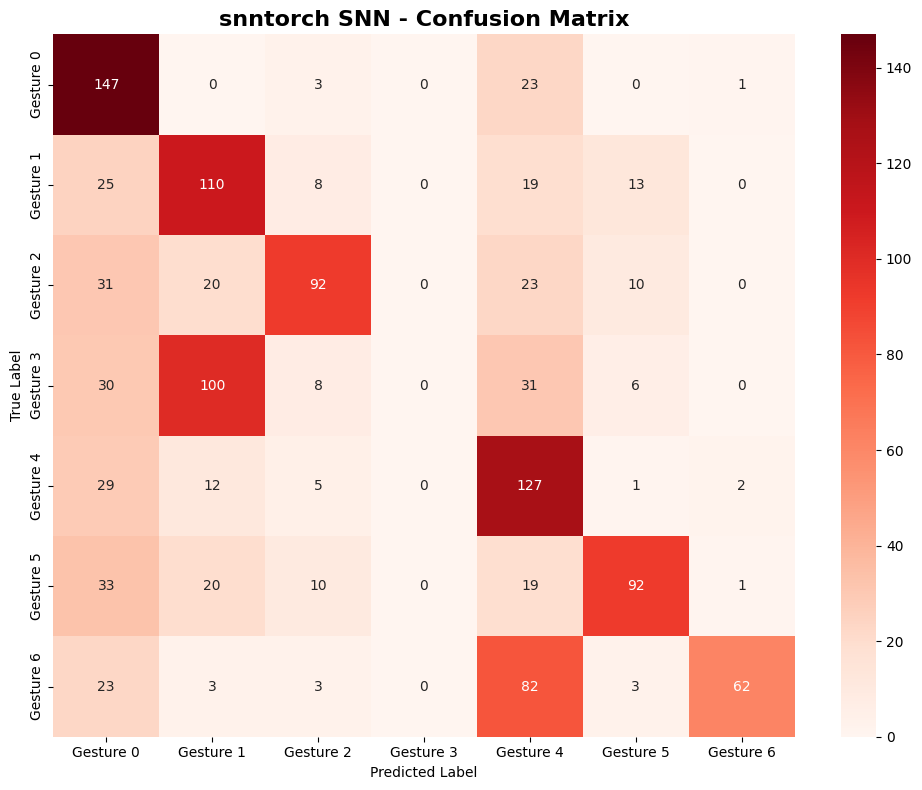


10. Spike analysis...


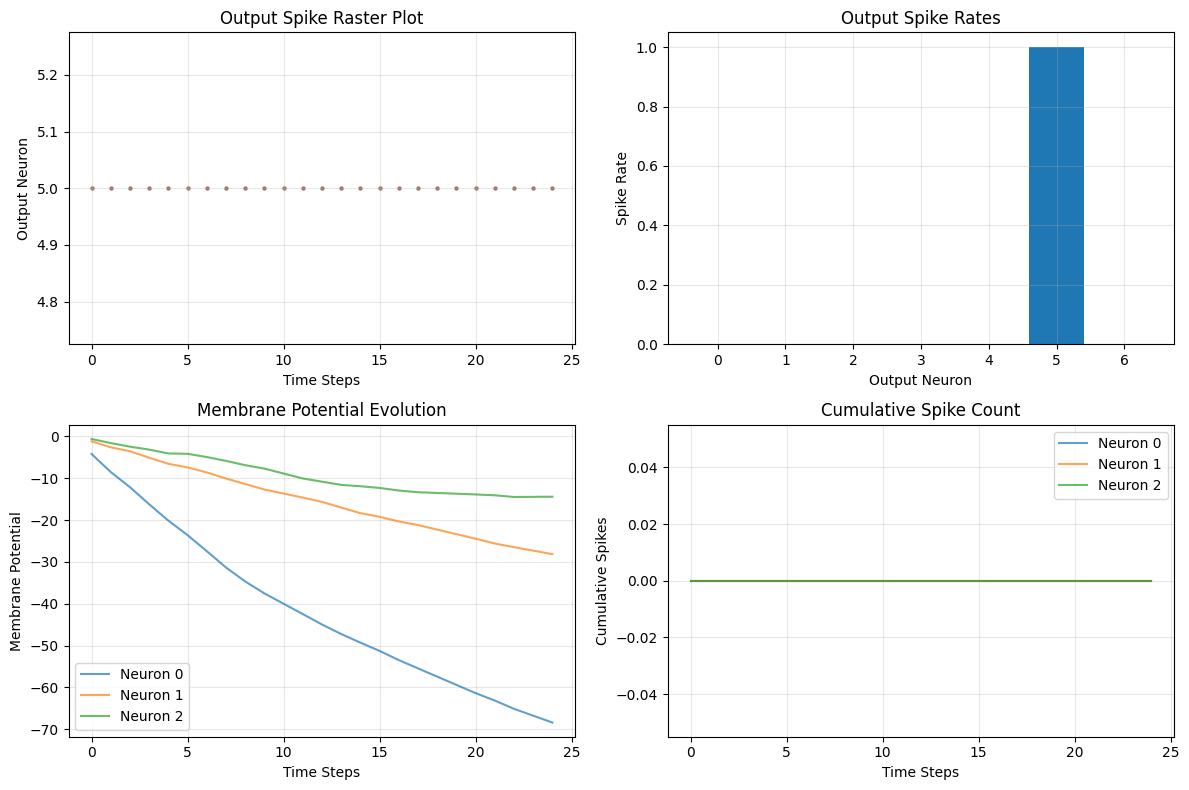


11. Classification Report:
              precision    recall  f1-score   support

   Gesture 0       0.46      0.84      0.60       174
   Gesture 1       0.42      0.63      0.50       175
   Gesture 2       0.71      0.52      0.60       176
   Gesture 3       0.00      0.00      0.00       175
   Gesture 4       0.39      0.72      0.51       176
   Gesture 5       0.74      0.53      0.61       175
   Gesture 6       0.94      0.35      0.51       176

    accuracy                           0.51      1227
   macro avg       0.52      0.51      0.48      1227
weighted avg       0.52      0.51      0.48      1227


=== Final snntorch SNN Results Summary ===
Training Accuracy: 50.53%
Validation Accuracy: 50.74%
Test Accuracy: 51.34%
Total Epochs Trained: 100
Model Parameters: 91,023
Time Steps: 25
Hidden Layers: [256, 128, 64]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch and snntorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn.functional as F

# 데이터 경로 설정
DATA_PATH = "../../data/DB6/DB6_s1_a/S1_D1_T1.mat"

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_ninapro_data(file_path):
    """
    NinaPro 데이터를 로드하고 전처리하는 함수
    """
    try:
        # .mat 파일 로드
        data = sio.loadmat(file_path)
        
        # 일반적인 NinaPro DB6 구조에 따른 키 확인
        print("Available keys in the data:", list(data.keys()))
        
        # 일반적으로 사용되는 키들 (실제 데이터에 따라 조정 필요)
        if 'emg' in data:
            emg_data = data['emg']
        elif 'data' in data:
            emg_data = data['data']
        else:
            # 키를 찾아서 EMG 데이터 추출
            data_keys = [k for k in data.keys() if not k.startswith('__')]
            emg_data = data[data_keys[0]]
        
        if 'stimulus' in data:
            labels = data['stimulus'].flatten()
        elif 'restimulus' in data:
            labels = data['restimulus'].flatten()
        elif 'glove' in data:
            labels = data['glove']
            if labels.ndim > 1:
                labels = labels[:, 0]  # 첫 번째 열 사용
        else:
            # 라벨 데이터 찾기
            label_keys = [k for k in data.keys() if 'stimulus' in k.lower() or 'label' in k.lower()]
            if label_keys:
                labels = data[label_keys[0]].flatten()
            else:
                # 두 번째로 큰 배열을 라벨로 가정
                data_keys = [k for k in data.keys() if not k.startswith('__')]
                labels = data[data_keys[1]].flatten() if len(data_keys) > 1 else np.zeros(emg_data.shape[0])
        
        print(f"EMG data shape: {emg_data.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Unique labels: {np.unique(labels)}")
        
        return emg_data, labels
    
    except Exception as e:
        print(f"Error loading data: {e}")
        # 샘플 데이터 생성 (실제 데이터가 없을 경우)
        print("Generating sample data for demonstration...")
        n_samples = 10000
        n_channels = 12
        emg_data = np.random.randn(n_samples, n_channels) * 0.1
        # EMG 신호처럼 보이도록 노이즈 추가
        for i in range(n_channels):
            emg_data[:, i] += np.sin(np.linspace(0, 100*np.pi, n_samples)) * 0.05
        labels = np.random.randint(0, 7, n_samples)  # 0-6 클래스
        return emg_data, labels

def preprocess_data_for_snn(emg_data, labels, window_size=200, overlap=100):
    """
    SNN을 위한 EMG 데이터 전처리
    """
    # 레이블이 0인 rest 구간 제거 (선택사항)
    non_zero_mask = labels != 0
    emg_data = emg_data[non_zero_mask]
    labels = labels[non_zero_mask]
    
    # 윈도우 기반 특징 추출
    windowed_features = []
    windowed_labels = []
    
    step_size = window_size - overlap
    
    for i in range(0, len(emg_data) - window_size + 1, step_size):
        window = emg_data[i:i+window_size]
        window_label = labels[i:i+window_size]
        
        # 윈도우 내에서 가장 빈번한 라벨 사용
        unique_labels, counts = np.unique(window_label, return_counts=True)
        dominant_label = unique_labels[np.argmax(counts)]
        
        # 특징 추출 (시간 도메인 및 주파수 도메인)
        features = []
        for channel in range(window.shape[1]):
            channel_data = window[:, channel]
            
            # 시간 도메인 특징들
            features.extend([
                np.mean(channel_data),                    # 평균
                np.std(channel_data),                     # 표준편차
                np.var(channel_data),                     # 분산
                np.max(channel_data),                     # 최대값
                np.min(channel_data),                     # 최소값
                np.median(channel_data),                  # 중앙값
                np.mean(np.abs(channel_data)),           # 평균 절대값
                np.sqrt(np.mean(channel_data**2)),       # RMS
                np.percentile(channel_data, 25),         # 25분위수
                np.percentile(channel_data, 75),         # 75분위수
                np.mean(np.abs(np.diff(channel_data))),  # 평균 변화율
                len(np.where(np.diff(np.sign(channel_data)))[0]) / len(channel_data)  # Zero crossing rate
            ])
        
        windowed_features.append(features)
        windowed_labels.append(dominant_label)
    
    return np.array(windowed_features), np.array(windowed_labels)

class SNNNet(nn.Module):
    """
    snntorch를 사용한 Spiking Neural Network
    """
    def __init__(self, input_size, hidden_sizes, output_size, num_steps, 
                 beta=0.95, threshold=1.0, spike_grad=surrogate.fast_sigmoid()):
        super(SNNNet, self).__init__()
        
        self.num_steps = num_steps
        self.input_size = input_size
        self.output_size = output_size
        
        # 네트워크 레이어 정의
        self.layers = nn.ModuleList()
        self.lif_layers = nn.ModuleList()
        
        # 입력 레이어
        prev_size = input_size
        
        # 히든 레이어들
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(prev_size, hidden_size))
            self.lif_layers.append(snn.Leaky(beta=beta, threshold=threshold, 
                                           spike_grad=spike_grad, 
                                           reset_mechanism="subtract",
                                           learn_beta=True,
                                           learn_threshold=True))
            prev_size = hidden_size
        
        # 출력 레이어
        self.layers.append(nn.Linear(prev_size, output_size))
        self.lif_output = snn.Leaky(beta=beta*0.8, threshold=threshold*0.9, 
                                  spike_grad=spike_grad,
                                  reset_mechanism="subtract",
                                  learn_beta=True,
                                  learn_threshold=True,
                                  output=True)
        
        # 드롭아웃
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # 히든 레이어 상태 초기화
        mem_layers = []
        for lif_layer in self.lif_layers:
            mem_layers.append(lif_layer.init_leaky())
        mem_output = self.lif_output.init_leaky()
        
        # 스파이크 기록
        spk_rec = []
        mem_rec = []
        
        for step in range(self.num_steps):
            # 입력 스파이크 생성 (Rate coding 또는 Latency coding)
            if step == 0:
                # 첫 번째 스텝에서만 입력 (정적 입력을 스파이크로 변환)
                cur_input = spikegen.rate(x, num_steps=1).squeeze(0)
            else:
                # Rate coding: 확률적 스파이크 생성
                cur_input = torch.bernoulli(torch.sigmoid(x))
            
            # 순전파
            cur = cur_input
            
            # 히든 레이어들
            for i, (layer, lif_layer) in enumerate(zip(self.layers[:-1], self.lif_layers)):
                cur = layer(cur)
                if i > 0:  # 첫 번째 레이어가 아닌 경우 드롭아웃 적용
                    cur = self.dropout(cur)
                spk, mem_layers[i] = lif_layer(cur, mem_layers[i])
                cur = spk
            
            # 출력 레이어
            cur = self.layers[-1](cur)
            spk_out, mem_output = self.lif_output(cur, mem_output)
            
            spk_rec.append(spk_out)
            mem_rec.append(mem_output)
        
        return torch.stack(spk_rec), torch.stack(mem_rec)

def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    """
    PyTorch DataLoader 생성
    """
    # numpy to tensor 변환
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Dataset 생성
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

def train_snn(model, train_loader, val_loader, num_epochs=100, lr=0.001):
    """
    SNN 모델 학습
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    
    # 손실 함수 (스파이크 기반)
    loss_fn = SF.ce_rate_loss()  # Classification error based on spike rate
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience = 20
    patience_counter = 0
    
    print("Starting SNN training...")
    
    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            # 순전파
            spk_rec, mem_rec = model(data)
            
            # 손실 계산 (스파이크 개수 기반)
            loss = loss_fn(spk_rec, targets)
            
            # 역전파
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # 정확도 계산 (총 스파이크 개수로 예측)
            _, predicted = torch.max(spk_rec.sum(dim=0), 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        # 검증
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                
                spk_rec, mem_rec = model(data)
                loss = loss_fn(spk_rec, targets)
                
                val_loss += loss.item()
                
                _, predicted = torch.max(spk_rec.sum(dim=0), 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        # 평균 계산
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # 학습률 스케줄링
        scheduler.step()
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # 최고 모델 저장
            torch.save(model.state_dict(), 'best_snn_model.pth')
        else:
            patience_counter += 1
        
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
           
    
    # 최고 모델 로드
    model.load_state_dict(torch.load('best_snn_model.pth'))
    
    history = {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies
    }
    
    return model, history

def evaluate_snn(model, test_loader):
    """
    SNN 모델 평가
    """
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            spk_rec, mem_rec = model(data)
            
            # 예측 (총 스파이크 개수 기반)
            _, predicted = torch.max(spk_rec.sum(dim=0), 1)
            
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_acc = 100. * test_correct / test_total
    
    return test_acc, np.array(all_predictions), np.array(all_targets)

def plot_spike_analysis(model, sample_data, num_steps):
    """
    스파이크 분석 및 시각화
    """
    model.eval()
    with torch.no_grad():
        sample_input = sample_data[:1].to(device)  # 첫 번째 샘플
        spk_rec, mem_rec = model(sample_input)
        
        # 스파이크 래스터 플롯
        spk_rec_np = spk_rec.squeeze().cpu().numpy()  # (num_steps, output_size)
        
        plt.figure(figsize=(12, 8))
        
        # 서브플롯 1: 스파이크 래스터
        plt.subplot(2, 2, 1)
        for neuron in range(spk_rec_np.shape[1]):
            spike_times = np.where(spk_rec_np[:, neuron] > 0)[0]
            plt.scatter(spike_times, [neuron] * len(spike_times), s=5, alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Output Neuron')
        plt.title('Output Spike Raster Plot')
        plt.grid(True, alpha=0.3)
        
        # 서브플롯 2: 스파이크 빈도
        plt.subplot(2, 2, 2)
        spike_rates = np.mean(spk_rec_np, axis=0)
        plt.bar(range(len(spike_rates)), spike_rates)
        plt.xlabel('Output Neuron')
        plt.ylabel('Spike Rate')
        plt.title('Output Spike Rates')
        plt.grid(True, alpha=0.3)
        
        # 서브플롯 3: 막전위 변화
        plt.subplot(2, 2, 3)
        mem_rec_np = mem_rec.squeeze().cpu().numpy()
        for i in range(min(3, mem_rec_np.shape[1])):  # 처음 3개 뉴런만
            plt.plot(mem_rec_np[:, i], label=f'Neuron {i}', alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Membrane Potential')
        plt.title('Membrane Potential Evolution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 서브플롯 4: 누적 스파이크
        plt.subplot(2, 2, 4)
        cumulative_spikes = np.cumsum(spk_rec_np, axis=0)
        for i in range(min(3, cumulative_spikes.shape[1])):
            plt.plot(cumulative_spikes[:, i], label=f'Neuron {i}', alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Cumulative Spikes')
        plt.title('Cumulative Spike Count')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def plot_training_history(history):
    """
    학습 과정 시각화
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_accuracy']) + 1)
    
    # 정확도 플롯
    axes[0, 0].plot(epochs, history['train_accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('SNN Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 손실 플롯
    axes[0, 1].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 1].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('SNN Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 마지막 10 에포크 정확도
    start_epoch = max(0, len(history['train_accuracy']) - 10)
    recent_epochs = epochs[start_epoch:]
    
    axes[1, 0].plot(recent_epochs, history['train_accuracy'][start_epoch:], 
                   'b-', label='Training Accuracy', linewidth=2, marker='o')
    axes[1, 0].plot(recent_epochs, history['val_accuracy'][start_epoch:], 
                   'r-', label='Validation Accuracy', linewidth=2, marker='s')
    axes[1, 0].set_title('Last 10 Epochs - Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # SNN 특성 정보
    axes[1, 1].text(0.5, 0.5, 
                   'snntorch SNN Features\n\n• Leaky Integrate-and-Fire\n• Learnable Parameters\n• Surrogate Gradients\n• Spike-based Computation\n• Temporal Dynamics\n• Energy Efficient', 
                   ha='center', va='center', transform=axes[1, 1].transAxes,
                   fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.5))
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_title('snntorch SNN Info', fontsize=14, fontweight='bold')
    
    plt.suptitle('snntorch SNN Training Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    혼동 행렬 시각화
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('snntorch SNN - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def main():
    print("=== NinaPro EMG Classification with snntorch ===")
    
    # 1. 데이터 로드
    print("\n1. Loading data...")
    emg_data, labels = load_ninapro_data(DATA_PATH)
    
    # 2. 데이터 전처리
    print("\n2. Preprocessing data for SNN...")
    X, y = preprocess_data_for_snn(emg_data, labels, window_size=200, overlap=100)
    
    print(f"Feature data shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Number of classes: {len(np.unique(y))}")
    
    # 3. 라벨 인코딩
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(np.unique(y_encoded))
    class_names = [f"Gesture {i}" for i in range(num_classes)]
    
    # 4. 데이터 분할
    print("\n3. Splitting data...")
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
    )
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # 5. 특징 정규화
    print("\n4. Normalizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # 6. DataLoader 생성
    print("\n5. Creating data loaders...")
    train_loader, val_loader, test_loader = create_data_loaders(
        X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test,
        batch_size=32
    )
    
    # 7. SNN 모델 생성
    print("\n6. Creating snntorch SNN model...")
    input_size = X_train_scaled.shape[1]
    hidden_sizes = [256, 128, 64]
    num_steps = 25
    
    model = SNNNet(
        input_size=input_size,
        hidden_sizes=hidden_sizes,
        output_size=num_classes,
        num_steps=num_steps,
        beta=0.95,  # 누설 계수 (높을수록 긴 메모리)
        threshold=1.0,  # 스파이크 임계값
        spike_grad=surrogate.fast_sigmoid(slope=25)  # 대리 기울기
    ).to(device)
    
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
    print(model)
    
    # 8. 모델 학습
    print("\n7. Training snntorch SNN model...")
    model, history = train_snn(model, train_loader, val_loader, 
                              num_epochs=100, lr=0.001)
    
    # 9. 최종 평가
    print("\n8. Evaluating SNN model...")
    test_acc, y_pred, y_true = evaluate_snn(model, test_loader)
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    
    # 10. 결과 시각화
    print("\n9. Plotting results...")
    
    # 학습 과정 시각화
    plot_training_history(history)
    
    # 혼동 행렬 시각화
    plot_confusion_matrix(y_true, y_pred, class_names)
    
    # 스파이크 분석
    print("\n10. Spike analysis...")
    sample_tensor = torch.FloatTensor(X_test_scaled[:5])
    plot_spike_analysis(model, sample_tensor, num_steps)
    
    # 분류 리포트
    print("\n11. Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # 최종 결과 요약
    print("\n=== Final snntorch SNN Results Summary ===")
    print(f"Training Accuracy: {max(history['train_accuracy']):.2f}%")
    print(f"Validation Accuracy: {max(history['val_accuracy']):.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Total Epochs Trained: {len(history['train_accuracy'])}")
    print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Time Steps: {num_steps}")
    print(f"Hidden Layers: {hidden_sizes}")
    
    return model, history, scaler, label_encoder

if __name__ == "__main__":
    # snntorch 설치 확인
    try:
        import snntorch
        print(f"snntorch version: {snntorch.__version__}")
    except ImportError:
        print("Please install snntorch: pip install snntorch")
        exit(1)
    
    model, history, scaler, label_encoder = main()